In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from bitlinear158 import BitLinear158, BitLinear158Inference
from RMSNorm import RMSNorm

In [2]:
def generate_gaussian_data(n_samples=1000, mean=[0, 0], cov=[[1, 0],[0, 1]]):
    data = np.random.multivariate_normal(mean, cov, n_samples)
    return torch.tensor(data, dtype=torch.float32)


In [3]:
torch.manual_seed(0)
# data = torch.vstack((generate_gaussian_data(cov=[[1, 1],[1, 1]]), generate_gaussian_data(cov=[[1,-1],[-1,1]])))
# data = torch.vstack((generate_gaussian_data(mean=[1,1]), generate_gaussian_data(cov=[[1,-1],[-1,1]])))

# data = torch.vstack((generate_gaussian_data(mean=[10,10]) , generate_gaussian_data(mean=[-10,-10])))
data = generate_gaussian_data()


In [4]:
device='cpu'

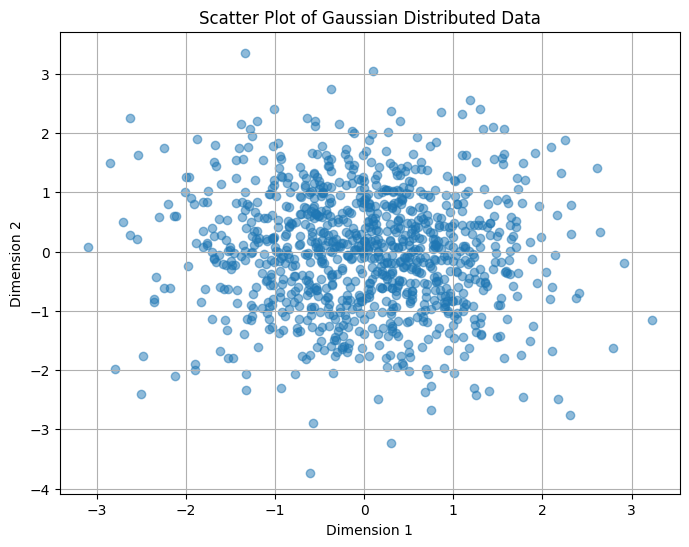

In [5]:
def plot_data(data):
    """Plot 2D data using a scatter plot."""
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
    plt.title('Scatter Plot of Gaussian Distributed Data')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()

plot_data(data)


In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, device = device):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.fc1 = BitLinear158(input_dim, 200)
        self.fc2 = BitLinear158(200, 200)
        self.fc3 = BitLinear158(200, 200)
        self.fc31 = BitLinear158(200, latent_dim)  # For mu
        self.fc32 = BitLinear158(200, latent_dim)  # For log variance

        

        # Decoder
        self.decoder = nn.Sequential(
            BitLinear158(latent_dim, 100),
            nn.LeakyReLU(0.),
            #RMSNorm(100),
            BitLinear158(100, 100),
            nn.LeakyReLU(0.0),
            #RMSNorm(100),
            BitLinear158(100, 100),
            nn.LeakyReLU(0.2),
            #RMSNorm(100),
            BitLinear158(100, 100),
            nn.LeakyReLU(0.2),
            #RMSNorm(100),
            # BitLinear158(100, 100),
            # nn.LeakyReLU(0.),
            # RMSNorm(100),
            # BitLinear158(100, 100),
            # nn.LeakyReLU(0.),
            # RMSNorm(100),

            
            # BitLinear158(100, 100),
            # nn.LeakyReLU(0.),
            # BitLinear158(100, 100),
            # nn.LeakyReLU(0.),
            # BitLinear158(100, 100),
            # nn.LeakyReLU(0.),
            # BitLinear158(100, 100),
            # nn.LeakyReLU(0.),
            BitLinear158(100, input_dim)
       )

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        return self.fc31(h3), self.fc32(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar).to(device)
        eps = torch.randn_like(std).to(device)
        mu.to(device)
        return mu + eps * std

    def decode(self, z):
        # TODO : 
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode_latent(self, x):
        with torch.no_grad():
            mu, logvar = self.encode(x)
            return mu, logvar

In [7]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction="sum")

    # # Binary cross-entropy loss for reconstruction
    # bce_loss = nn.BCELoss(reduction='none')
    # # bce expects inputs to be in range [0,1] is clamp a good solution ? 
    # recon_x = torch.clamp(recon_x, 0, 1)
    # x = torch.clamp(x, 0, 1)
    # recon_loss = bce_loss(recon_x, x).sum(dim=1)
    # # print(recon_loss)
    
    # # Maximum ENLL (Max-ENLL)
    # max_enll = torch.max(recon_loss)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # TODO: report MSE and KL seperately for debugging 
    
    return MSE + KL, MSE, KL

In [8]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=3e-4)
data_loader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)


Train Epoch: 0  Loss: 56.036325
Train Epoch: 1  Loss: 51.429685
Train Epoch: 2  Loss: 50.478163
Train Epoch: 3  Loss: 50.514089
Train Epoch: 4  Loss: 50.253965
Train Epoch: 5  Loss: 50.208561
Train Epoch: 6  Loss: 50.455001
Train Epoch: 7  Loss: 50.027060
Train Epoch: 8  Loss: 50.328094
Train Epoch: 9  Loss: 49.989464
Train Epoch: 10  Loss: 49.496733
Train Epoch: 11  Loss: 48.651647
Train Epoch: 12  Loss: 45.612962
Train Epoch: 13  Loss: 44.748500
Train Epoch: 14  Loss: 43.463777
Train Epoch: 15  Loss: 43.866325
Train Epoch: 16  Loss: 44.056006
Train Epoch: 17  Loss: 44.024707
Train Epoch: 18  Loss: 44.443922
Train Epoch: 19  Loss: 43.499547
Train Epoch: 20  Loss: 43.433515
Train Epoch: 21  Loss: 44.268591
Train Epoch: 22  Loss: 43.497188
Train Epoch: 23  Loss: 43.338581
Train Epoch: 24  Loss: 43.223324
Train Epoch: 25  Loss: 42.061917
Train Epoch: 26  Loss: 42.622815
Train Epoch: 27  Loss: 44.713655
Train Epoch: 28  Loss: 44.020609
Train Epoch: 29  Loss: 43.697197
Train Epoch: 30  Los

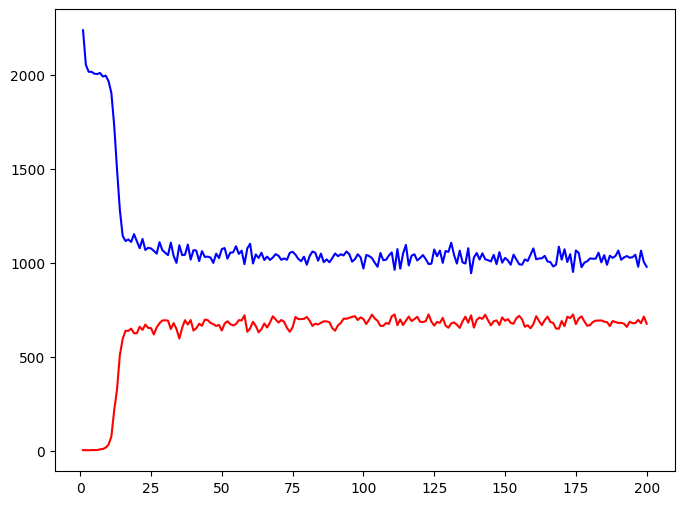

In [9]:
max_enll_array = np.array([])
kl_array = np.array([])
for epoch in range(200):
    model.train()
    train_loss = 0
    max_enll_loss = 0 
    kl_loss = 0 
    for batch_idx, data in enumerate(data_loader):
        optimizer.zero_grad()
        data.to(device)
        recon_batch, mu, logvar = model(data)
        loss, max_enll, kl = loss_function(recon_batch, data, mu, logvar)
        train_loss += loss.item()
        max_enll_loss += max_enll.item()
        kl_loss += kl.item()
        loss.backward()
        optimizer.step()

    max_enll_array = np.append(max_enll_array,max_enll_loss)
    kl_array =  np.append(kl_array,kl_loss)

    print(
        f"Train Epoch: {epoch}  Loss: {train_loss / len(data):.6f}"
    )

epochs = np.arange(1, 201)
plt.figure(figsize=(8, 6))  
plt.plot(epochs, max_enll_array, label='Reconstruction Loss', color='blue')
plt.plot(epochs, kl_array, label='KL Divergence', color='red')


In [10]:
kl_array

array([  2.6716654 ,   2.39245465,   1.65463516,   2.86221159,
         2.79960021,   2.67897379,   6.79526225,   8.55217141,
        15.7882269 ,  31.59910047,  74.32338786, 213.97970295,
       325.97562599, 508.38178253, 594.86464119, 638.34516525,
       637.80506897, 649.57779121, 625.01578903, 624.75883484,
       659.56873322, 643.25844955, 671.1794548 , 653.39806938,
       652.29803085, 618.6667881 , 655.90396309, 678.55911446,
       692.92241287, 694.01239967, 692.18810272, 647.71507454,
       678.9480896 , 647.29298782, 596.80722618, 654.22232246,
       694.37591934, 671.75855446, 695.1015625 , 639.39856339,
       651.64616013, 675.85933685, 664.7879734 , 697.54328728,
       695.34923553, 680.26233673, 673.29861259, 663.83248138,
       669.42224121, 639.44874954, 676.84104538, 688.75175476,
       673.39277267, 666.62002754, 673.95275688, 694.83218002,
       693.03184891, 720.52745056, 632.89992714, 651.05097389,
       686.15205765, 663.5728035 , 629.8734417 , 647.06

In [11]:
latent_variables = []
for data in data_loader:
    mu, logvar = model.encode_latent(data)
    z = model.reparameterize(mu, logvar)
    latent_variables.append(z)
latent_variables = torch.cat(latent_variables, 0)


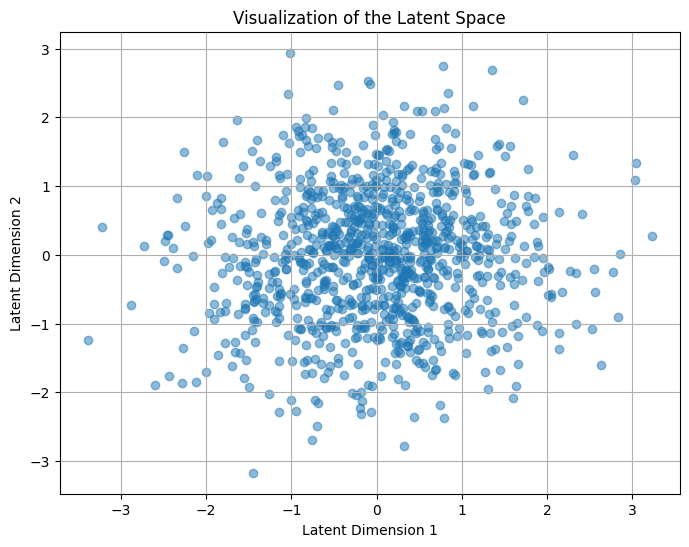

In [12]:

x, y = latent_variables[:, 0].numpy(), latent_variables[:, 1].numpy()

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Visualization of the Latent Space')
plt.grid(True)
plt.show()

In [13]:
print(model)

VAE(
  (fc1): BitLinear158(in_features=2, out_features=200, bias=True)
  (fc2): BitLinear158(in_features=200, out_features=200, bias=True)
  (fc3): BitLinear158(in_features=200, out_features=200, bias=True)
  (fc31): BitLinear158(in_features=200, out_features=2, bias=True)
  (fc32): BitLinear158(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): BitLinear158(in_features=2, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.0)
    (2): RMSNorm()
    (3): BitLinear158(in_features=100, out_features=100, bias=True)
    (4): LeakyReLU(negative_slope=0.0)
    (5): RMSNorm()
    (6): BitLinear158(in_features=100, out_features=100, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): RMSNorm()
    (9): BitLinear158(in_features=100, out_features=100, bias=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): RMSNorm()
    (12): BitLinear158(in_features=100, out_features=2, bias=True)
  )
)


In [14]:
model.fc31.weight

Parameter containing:
tensor([[-0.0001, -0.0013,  0.0737,  0.0938,  0.0598,  0.0551,  0.0482, -0.0683,
          0.0141, -0.0889, -0.0465, -0.0419, -0.0439, -0.0613,  0.0098,  0.0016,
         -0.0192,  0.0600, -0.0227,  0.0603, -0.0089,  0.0055, -0.0597,  0.0492,
          0.0522, -0.0067, -0.0188,  0.0365,  0.0128,  0.0789, -0.0586,  0.0440,
          0.0257,  0.0656,  0.0079,  0.0658,  0.0405,  0.0255,  0.0301, -0.0523,
         -0.1004,  0.0328,  0.0180, -0.0275, -0.0305,  0.0221,  0.0111, -0.0183,
         -0.0145,  0.0550, -0.0495, -0.0498,  0.0169, -0.0588, -0.0971, -0.0379,
         -0.0629, -0.0621, -0.0756,  0.0162,  0.0390,  0.0370, -0.0582,  0.0383,
          0.0551,  0.0823, -0.0653,  0.0560, -0.0106,  0.0772,  0.0091, -0.0027,
         -0.0340, -0.0558, -0.0297,  0.0495, -0.0262, -0.1022, -0.0350, -0.0760,
          0.0364,  0.0517, -0.0521,  0.0220, -0.0623, -0.0572,  0.0181,  0.0831,
         -0.0104,  0.0597, -0.0111, -0.0347,  0.0093, -0.0126, -0.0586,  0.0125,
      

In [15]:
def change_to_inference(model):
    
    bitlinear_layers  = [(k, m) for k, m in model.named_modules() if type(m).__name__ == 'BitLinear158'] 
    for name, layer in bitlinear_layers:
        layer.beta = 1 / layer.weight.abs().mean().clamp(min=1e-5)
        layer.weight = nn.Parameter((layer.weight * layer.beta).round().clamp(-1, 1))
        layer.weight.detach()
        layer.weight.requires_grad = False
        new_layer = BitLinear158Inference(layer.input_dim, layer.output_dim)  
        new_layer.weight.data = layer.weight.data.clone()
        new_layer.beta = layer.beta
        setattr(model, name, new_layer)

change_to_inference(model)
change_to_inference(model.decoder)


In [16]:
bitlinear_layers  = [(k, m) for k, m in model.named_modules() if type(m).__name__ == 'BitLinear158']

In [17]:
print(model)

VAE(
  (fc1): BitLinear158Inference(in_features=2, out_features=200, bias=True)
  (fc2): BitLinear158Inference(in_features=200, out_features=200, bias=True)
  (fc3): BitLinear158Inference(in_features=200, out_features=200, bias=True)
  (fc31): BitLinear158Inference(in_features=200, out_features=2, bias=True)
  (fc32): BitLinear158Inference(in_features=200, out_features=2, bias=True)
  (decoder): Sequential(
    (0): BitLinear158Inference(in_features=2, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.0)
    (2): RMSNorm()
    (3): BitLinear158Inference(in_features=100, out_features=100, bias=True)
    (4): LeakyReLU(negative_slope=0.0)
    (5): RMSNorm()
    (6): BitLinear158Inference(in_features=100, out_features=100, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): RMSNorm()
    (9): BitLinear158Inference(in_features=100, out_features=100, bias=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): RMSNorm()
    (12): BitLinear158Inference(in_features=100, 

In [18]:
def sample_from_vae(model, n_samples=100, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Sample from a standard normal distribution
        z = torch.randn(n_samples, model.latent_dim).to(device) 
        
        # Decode the sample
        sampled_data = model.decode(z)
    return sampled_data


In [19]:
n_samples =500
generated_data = sample_from_vae(model, n_samples=n_samples, device='cpu')

generated_data = generated_data.cpu().numpy()


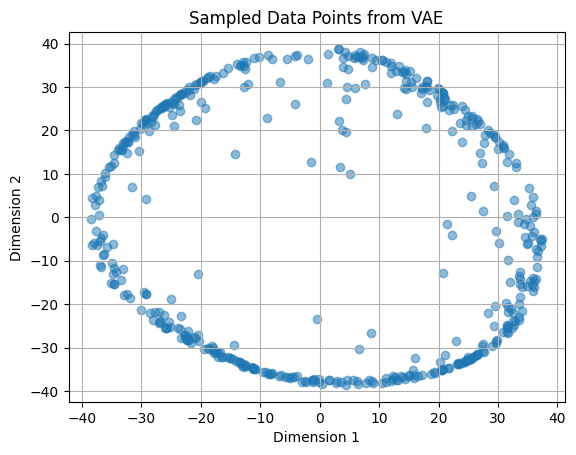

In [20]:
plt.scatter(generated_data[:, 0], generated_data[:, 1], alpha=0.5)
plt.title("Sampled Data Points from VAE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


In [21]:
generated_data.mean(axis=0)

array([ 0.71270424, -1.8120071 ], dtype=float32)

In [22]:
tmp = torch.tensor([0.0,0.0])
tmp = tmp[:, None].T
model.decode(tmp)

tensor([[-4.5445,  7.9458]], grad_fn=<AddBackward0>)

In [23]:
model.encode(tmp)

(tensor([[0.0385, 0.0413]], grad_fn=<AddBackward0>),
 tensor([[-0.1741, -0.2049]], grad_fn=<AddBackward0>))

In [24]:
tmp = torch.tensor([0.0,1.0])

In [25]:
tmp = tmp[:, None]
tmp.T

tensor([[0., 1.]])

In [26]:
torch.max(z,dim = 0)

torch.return_types.max(
values=tensor([2.0135, 2.1716]),
indices=tensor([36, 29]))